# Exploration of Queries

## About

This Jupyter notebook is designed to demonstrate interactions with the [Data Store](https://github.com/HumanCellAtlas/data-store) generic query endpoint as well as the [Boardwalk](https://boardwalk.ucsc-cgl.org) file browser [index](https://github.com/BD2KGenomics/dss-azul-indexer).

## Query Data Store Search Endpoint

In this example, I'm querying the search endpoint on the Data Store directly (see the Swagger docs [here](https://dss.staging.data.humancellatlas.org/)).  I do that twice, first to find all the bundles matching "Human" and with `*.fastq.gz` files.  The latter is a proxy for upload bundles until we have a distinct upload bundle type as documented in the `submission.json`.  The second query looks for all bundles that include an `analysis.json` which is an indication they are the result of analysis.

Once I have these two lists I can download metadata files for each bundle, parse them, identify the donor for each bundle, and then determine which donors have fastq files uploaded but lack the analysis result and are, therefore, candidates for running a pipeline on.

In a real production system more terms would be added to the queries to ensure particular bundle types are selected, that specific workflows are checked, etc.  But as a proof of concept this shows how someone could query the indexes to make a decision about analysis.

Here's an example query for a given bundle's [file manifest](https://dss.staging.data.humancellatlas.org/v1/bundles/a84fb559-53ca-46cb-8996-0aa2332b27e2?version=2017-09-26T154508.206024Z&replica=aws).


In [7]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import urllib.parse
import urllib.request
import json


# this allows plots to appear directly in the notebook
%matplotlib inline

# read URL
def read_url(url):
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
        return(response.read())

# remove donors from one array based on content of another
def print_analysis_candidates(donors, donors_to_subtract):
    result = {}
    for donor in donors:
        donor_id = list(donor.keys())[0]
        donor_match = False
        for donor_to_subtract in donors_to_subtract:
            donor_id_to_subtract = list(donor_to_subtract.keys())[0]
            if (donor_id == donor_id_to_subtract):
                donor_match = True
                #print ("MATCHES - Donor "+donor_id+" matches "+donor_id_to_subtract+" and will be excluded")
        if(not donor_match):
            result[donor_id] = donor
    if (len(list(result.keys())) == 0):
        print ("NO DONORS SELECTED - no donors missing analysis")
    for donor_id in result.keys():
        print ("ANALYSIS - this donor should be analyzed: "+donor_id)
    
    
# parse sample info
def download_sample_info(uuid, version):
    sample_info = read_url('https://dss.staging.data.humancellatlas.org/v1/files/'+uuid+'?replica=aws&version='+version)
    sample_data = json.loads(sample_info)
    #print (sample_data['donor_id'])
    return(sample_data['donor_id'])
    
# parse bundle info to find donor ID
def parse_bundle_info(bundle_url):
    result_dict = {}
    bundle_info = read_url(bundle_url)
    bundle_data = json.loads(bundle_info)
    for file in bundle_data['bundle']['files']:
        if (file['name'] == 'sample.json'):
            donor_id = download_sample_info(file['uuid'], file['version'])
            result_dict[donor_id] = bundle_data
    return(result_dict)

# parse the query output and find bundle GUIDs
def parse_query_result(query_result):
    bundles = []
    q_results = json.loads(query_result)
    for bundle in q_results['results']:
        donor_info = parse_bundle_info(bundle['bundle_url'])
        bundles.append(donor_info)
    return(bundles)

# queries the search endpoint, returns the bundle GUIDs that match
def query_for_bundles(query, url):
    bundles = []
    headers = {"User-Agent": "Mozilla", 'accept': 'application/json', 'content-type': 'application/json'}
    data = json.dumps(query)
    data = data.encode('ascii') # data should be bytes
    req = urllib.request.Request(url, data, headers)
    with urllib.request.urlopen(req) as response:
        the_page = response.read()
        bundles = parse_query_result(the_page)
        return (bundles)
        
        
# queries
url = 'https://dss.staging.data.humancellatlas.org/v1/search?replica=aws'
query_analysis = {
 "es_query": {
   "query": {
     "bool": {
       "must": [
         {
           "match": {
             "manifest.files.name": "analysis.json"
           }
         },
         {
           "match": {
             "files.sample_json.donor.species.ontology": "9606"
           }
         },
         {
           "wildcard": {
             "manifest.files.name": "*bam"
           }
         }
       ]
     }
   }
 }
}
query_all = {
 "es_query": {
   "query": {
     "bool": {
       "must": [
         {
           "match": {
             "files.sample_json.donor.species.ontology": "9606"
           }
         },
         {
           "wildcard": {
             "manifest.files.name": "*fastq.gz"
           }
         }
       ]
     }
   }
 }
}

# now do the queries
print("\n#####################################################")
print("# FINDING DONORS FOR ANALYSIS USING BLUE BOX SEARCH #")
print("#####################################################")

print("Looking for donors matching query with analysis...")
donors_with_analysis = query_for_bundles(query_analysis, url)
print("Looking for all donors matching query... this will take a while...")
donors_all = query_for_bundles(query_all, url)

# go ahead and print summary for donors that don't have analysis
print_analysis_candidates(donors_all, donors_with_analysis)




#####################################################
# FINDING DONORS FOR ANALYSIS USING BLUE BOX SEARCH #
#####################################################
Looking for donors matching query with analysis...
Looking for all donors matching query... this will take a while...
NO DONORS SELECTED - no donors missing analysis


## Query Data Store Search Endpoint

In this example, I'm querying the search endpoint the [Boardwalk file index](https://github.com/BD2KGenomics/dss-azul-indexer).  I build my query by using the [Boardwalk portal](https://dss-aws-staging.ucsc-cgp-dev.org/boardwalk) and looking at the dev console for the API call URL.  This is an index that's built using events from the Data Store.  It focuses on transforming metadata for data bundles into a flat, file-oriented index structure that's easier to facet on in Boardwalk.

Here I'm doing a similar query to the above but the code is simplier since the file index has more information available than the current Data Store query endpoint.

First I'm looking for all analysis output for the workflow `Ss2RsemSingleSample` and human, cutting down to just the BAM files since I don't need to parse all the file resuts to find the donor.  Then I'm looking for all fastq uploads, with `None` workflow (indicating this is an upload) for human samples.  Finally, I intersect the two lists, looking for donors that have not had analysis performed on them.  Like the approach above, for a real production system this would include more details and filters.

Here's an example of what the API looks like for a query to find [all donors](https://dss-aws-staging.ucsc-cgp-dev.org/repository/files/?include=facets&from=1&size=500&filters=%7B%22file%22:%7B%22computationalMethod%22:%7B%22is%22:%5B%22None%22%5D%7D,%22donorSpecies%22:%7B%22is%22:%5B%22Homo%20sapiens%22%5D%7D,%22fileFormat%22:%7B%22is%22:%5B%22fastq.gz%22%5D%7D%7D%7D) and a query to find all donors with a [certain workflow result](https://dss-aws-staging.ucsc-cgp-dev.org/repository/files/?include=facets&from=1&size=500&filters=%7B%22file%22:%7B%22computationalMethod%22:%7B%22is%22:%5B%22Ss2RsemSingleSample%22%5D%7D,%22donorSpecies%22:%7B%22is%22:%5B%22Homo%20sapiens%22%5D%7D,%22fileFormat%22:%7B%22is%22:%5B%22toTranscriptome.out.bam%22%5D%7D%7D%7D).

In [8]:

# parse bundle info to find donor ID
def parse_bundle_info(bundle):
    result_dict = {}
    donor_id = bundle['donors'][0]['donorId']
    result_dict[donor_id] = bundle
    return(result_dict)
     
# parse the query output and find bundle GUIDs
def parse_query_result(query_result):
    bundles = []
    q_results = json.loads(query_result)
    for bundle in q_results['hits']:
        donor_info = parse_bundle_info(bundle)
        bundles.append(donor_info)
    return(bundles)        
        
# queries the search endpoint, returns the bundle GUIDs that match
def query_for_bundles(query, url):
    headers = {"User-Agent": "Mozilla", 'accept': 'application/json', 'content-type': 'application/json'}
    response = read_url(url+query)
    return(parse_query_result(response))
    
# queries
# made using the portal https://dss-aws-staging.ucsc-cgp-dev.org/boardwalk
url = 'https://dss-aws-staging.ucsc-cgp-dev.org/repository/files/?include=facets&from=1&size=500&filters='
query_analysis = '%7B"file":%7B"computationalMethod":%7B"is":%5B"Ss2RsemSingleSample"%5D%7D,"donorSpecies":%7B"is":%5B"Homo%20sapiens"%5D%7D,"fileFormat":%7B"is":%5B"toTranscriptome.out.bam"%5D%7D%7D%7D'
query_all = '%7B%22file%22:%7B%22computationalMethod%22:%7B%22is%22:%5B%22None%22%5D%7D,%22donorSpecies%22:%7B%22is%22:%5B%22Homo%20sapiens%22%5D%7D,%22fileFormat%22:%7B%22is%22:%5B%22fastq.gz%22%5D%7D%7D%7D'

# now do the queries
print("\n#####################################################")
print("# FINDING DONORS FOR ANALYSIS USING BOARDWALK INDEX #")
print("#####################################################")
print("Looking for donors matching query with analysis...")
donors_with_analysis = query_for_bundles(query_analysis, url)
print("Looking for all donors matching query...")
donors_all = query_for_bundles(query_all, url)

# go ahead and print summary for donors that don't have analysis
print_analysis_candidates(donors_all, donors_with_analysis)


#####################################################
# FINDING DONORS FOR ANALYSIS USING BOARDWALK INDEX #
#####################################################
Looking for donors matching query with analysis...
Looking for all donors matching query...
ANALYSIS - this donor should be analyzed: HP1504901
ANALYSIS - this donor should be analyzed: AZ
ANALYSIS - this donor should be analyzed: HP1502401
ANALYSIS - this donor should be analyzed: Q3_DEMO_donor1


## Lightweight Visualizations

Let's look at some information about the donors uploaded so far.

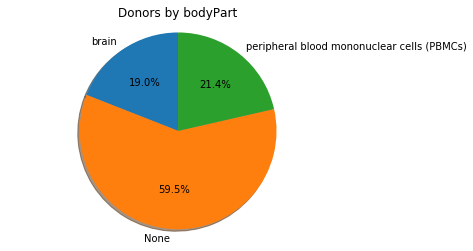

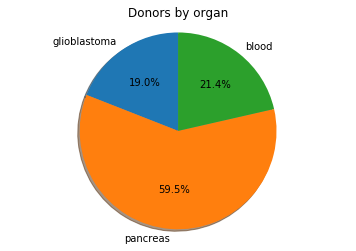

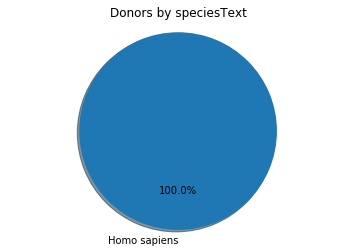

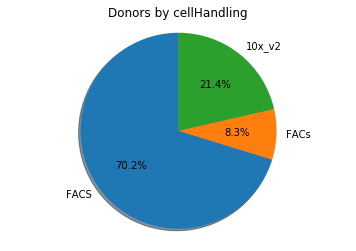

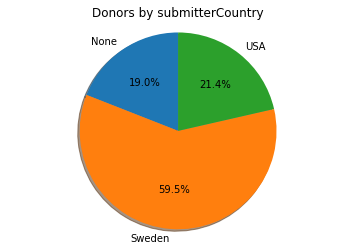

In [9]:
def print_donor_summary(field, donors):
    result = {}
    result['organ'] = {}
    for donor in donors:
        donor_id = list(donor.keys())[0]
        donor_data = donor[donor_id]
        if (not donor_data['donors'][0][field] in result['organ'].keys()):
            result['organ'][donor_data['donors'][0][field]] = 0
        result['organ'][donor_data['donors'][0][field]] = result['organ'][donor_data['donors'][0][field]] + 1
    labels = list(result['organ'].keys())
    sizes = list(result['organ'].values())
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Donors by '+field)
    plt.show()

def print_platform_summary(field, donors):
    result = {}
    result['platform'] = {}
    for donor in donors:
        donor_id = list(donor.keys())[0]
        donor_data = donor[donor_id]
        if (not donor_data['singleCell'][field] in result['platform'].keys()):
            result['platform'][donor_data['singleCell'][field]] = 0
        result['platform'][donor_data['singleCell'][field]] = result['platform'][donor_data['singleCell'][field]] + 1
    labels = list(result['platform'].keys())
    sizes = list(result['platform'].values())
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Donors by '+field)
    plt.show()    

def print_country_summary(field, donors):
    result = {}
    result['platform'] = {}
    for donor in donors:
        donor_id = list(donor.keys())[0]
        donor_data = donor[donor_id]
        if (not donor_data[field] in result['platform'].keys()):
            result['platform'][donor_data[field]] = 0
        result['platform'][donor_data[field]] = result['platform'][donor_data[field]] + 1
    labels = list(result['platform'].keys())
    sizes = list(result['platform'].values())
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Donors by '+field)
    plt.show() 

print_donor_summary('bodyPart', donors_all)
print_donor_summary('organ', donors_all)
print_donor_summary('speciesText', donors_all)
print_platform_summary('cellHandling', donors_all)
print_country_summary('submitterCountry', donors_all)